# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import tensorflow as tf
import gp_gpy as gp

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
n_segs = data.seg.unique()
synch_traj_n = 7 # traj 7 was used to train synch gps
route_n = 3 # all data used currently is from route 3

# These guys are not used as of now since all data comes from one route and one traj
def load_synch_gps(data):
    n_routes = [route_n] # should be computed from the data when all is done
    return {route_n: load_route_synch_gps(route_n) for route_n in n_routes}

def load_route_synch_gp(data, route_n):
    n_trajs = data.traj.unique()
    return {traj_n: load_traj_synch_gps(data[data.traj == traj_n], route_n, traj_n) for traj_n in n_trajs}

def load_traj_synch_gps(data, route_n, traj_n):
    n_segs = data.seg.unique()
    return {seg_n: load_seg_synch_gp(data[data.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
    
# This guy is used though
def load_seg_synch_gp(data, route_n, traj_n, seg_n):
    return gp.load(data, ['lat', 'lon'], ['progress'], 'synch', route_n, traj_n, seg_n)
    
n_segs = data.seg.unique()
synch_gps = {seg_n: load_seg_synch_gp(data, route_n, synch_traj_n, seg_n) for seg_n in n_segs}

## Training
With all that loaded we will now fit one GP for each segment in each trajectory. The function we want to fit is $f : \tau \mapsto \mathcal{R}^2$, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajecotry. As you might guess, this will take a while.

In [2]:
def train_gp(data, gps, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    synch = gps[seg_n]
    X = scale(seg[['lat', 'lon']].values)
    tau, _var = gp.predict(synch, X)
    synch_data = seg.copy()
    synch_data['tau'] = tau
    model = gp.build(synch_data, ['tau'], ['lat', 'lon'], 'pred-v1', route_n, traj_n, seg_n)
    gp.train(model, 5)
    gp.save(model)

for seg_n in n_segs: 
    train_gp(data, synch_gps, route_n, synch_traj_n, seg_n)


Optimization restart 1/5, f = -1519.8817050503096
Optimization restart 2/5, f = -1515.4293749281067
Optimization restart 3/5, f = -1515.4292864154638
Optimization restart 4/5, f = -1519.8816817617485
Optimization restart 5/5, f = -1515.4293267640148
Optimization restart 1/5, f = -1137.0118640978587
Optimization restart 2/5, f = -1143.189821437907
Optimization restart 3/5, f = -1143.1898141012957
Optimization restart 4/5, f = -1151.8304710767711
Optimization restart 5/5, f = -1143.189807922678
Optimization restart 1/5, f = -1441.7205996957375
Optimization restart 2/5, f = -1429.5613908595985
Optimization restart 3/5, f = -1429.5613985529048
Optimization restart 4/5, f = -1441.534201697509
Optimization restart 5/5, f = -1441.7282967201597
Optimization restart 1/5, f = -1014.8183215706918


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1016.3278320984389
Optimization restart 3/5, f = -1013.7323849419172
Optimization restart 4/5, f = -1015.6921592788176
Optimization restart 5/5, f = -1022.6663665515835
Optimization restart 1/5, f = -1691.9566682245686
Optimization restart 2/5, f = -1692.0474801687005
Optimization restart 3/5, f = -1692.0475167073187
Optimization restart 4/5, f = -1691.9689456132728
Optimization restart 5/5, f = -1692.047543007674
Optimization restart 1/5, f = -1542.027964376253


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1545.0776154058199
Optimization restart 3/5, f = -1543.7374184900864
Optimization restart 4/5, f = -1528.0816246272273
Optimization restart 5/5, f = -1543.6851712413006
Optimization restart 1/5, f = -2075.0255961403777
Optimization restart 2/5, f = -2075.7522122574087
Optimization restart 3/5, f = -2075.7363793692134
Optimization restart 4/5, f = -2075.751832230291
Optimization restart 5/5, f = -2075.7164588828305
Optimization restart 1/5, f = -1187.4260153695573
Optimization restart 2/5, f = -1187.4260341160812
Optimization restart 3/5, f = -1186.660810953164
Optimization restart 4/5, f = -1187.4260297829346
Optimization restart 5/5, f = -1187.4260161973345
Optimization restart 1/5, f = -3414.255854453567
Optimization restart 2/5, f = -3414.255935806481
Optimization restart 3/5, f = -3414.255859045228
Optimization restart 4/5, f = -3414.255885986574
Optimization restart 5/5, f = -3414.255653949922
Optimization restart 1/5, f = -1397.7290439007973
Optimiz

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:54: RuntimeWarning:invalid value encountered in multiply


Let's plot some of the GPs for their training data to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


-955053.3924045595
-1131895.7877770676
-2318939.584314132


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


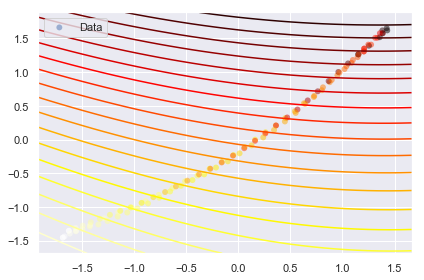

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


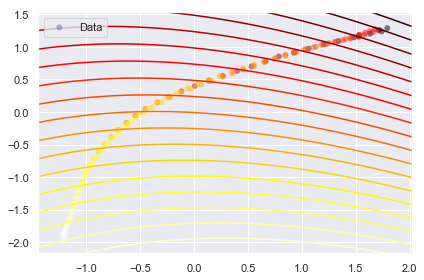

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


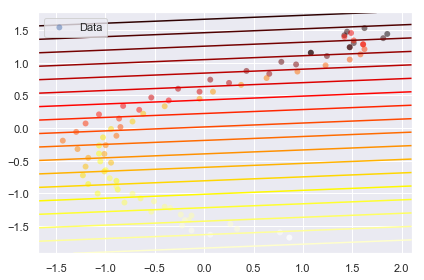

In [3]:
gp1 = gp.load(data[data.seg == 2], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 2)
gp2 = gp.load(data[data.seg == 3], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 3)
gp3 = gp.load(data[data.seg == 4], ['lat', 'lon'], ['progress'], 'pred-v1', route_n, synch_traj_n, 4)
gp.plot(gp1)
print(gp.loglik(gp1))
gp.plot(gp2)
print(gp.loglik(gp2))
gp.plot(gp3)
print(gp.loglik(gp3))

The results look reasonable, even though they are not amazing. It looks fairly likely that each process could have generated respective data.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

In [4]:
pred_gps = gp.load_all('pred-v1')

./gps/pred-v1\3.7.1.pkl
./gps/pred-v1\3.7.10.pkl
./gps/pred-v1\3.7.11.pkl
./gps/pred-v1\3.7.2.pkl
./gps/pred-v1\3.7.3.pkl
./gps/pred-v1\3.7.4.pkl
./gps/pred-v1\3.7.5.pkl
./gps/pred-v1\3.7.6.pkl
./gps/pred-v1\3.7.7.pkl
./gps/pred-v1\3.7.8.pkl
./gps/pred-v1\3.7.9.pkl


[GP(model=<GPy.models.gp_regression.GPRegression object at 0x0000015B6E94DC88>, X=array([[-0.79951333],
        [-0.79951333],
        [-0.79951333],
        [-0.92526398],
        [-0.81457692],
        [-0.90145243],
        [-0.9244724 ],
        [-0.92618809],
        [-0.89235731],
        [-0.77248103],
        [-0.41048219],
        [ 0.36144024],
        [ 1.16353283],
        [ 1.40134297],
        [ 1.27567953],
        [ 1.11873972],
        [ 0.98445019],
        [ 0.56133712],
        [ 0.24169652],
        [ 0.00540636],
        [-0.11168564],
        [-0.12294021],
        [-0.13257025],
        [-0.21650247],
        [-0.32529064],
        [-0.3981247 ],
        [-0.44292538],
        [-0.59734267],
        [-0.73816523],
        [-0.84052488],
        [-0.83662966],
        [-0.64804636],
        [-0.24287876],
        [ 0.40301674],
        [ 1.17953081],
        [ 1.73086521],
        [ 2.02714716],
        [ 1.93358327],
        [ 1.69059758],
        [ 1.39095168],